- 머신 러닝 모델 성능 평가
- 머신 러닝 알고리즘에서 일반적으로 발생하는 문제 분석
- 머신 러닝 모델 세부 튜닝
- 여러 가지 성능 지표를 사용하여 모델의 예측 성능 평가

# 1.파이프라인을 사용한 효율적인 워크 플로

- 테스트 데이터셋에 있는 별도의 샘플처럼 새로운 데이터의 스케일을 조정하고 압축하기 위해 훈련 데이터셋에서 학습한 파라미터를 재사용해야 함
- 이를 위해 아주 유용하게 사용할 수 있는 사이킷런의 `Pipeline`클래스를 사용

## 1.1.위스콘신 유방암 데이터 셋

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [2]:
from sklearn.preprocessing import LabelEncoder as LE

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LE()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(le.classes_)

array([0, 1])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)

## 1.2.파이프라인으로 변환기와 추정기 연결

- 위스콘신 유방암 데이터셋의 특성은 다양한 스케일로 측정되었기 때문에 LGR같은 선형 분류기에 주입하기 전에 특성을 표준화
- 차원 축소를 위한 특성 추출 기법으로 주성분 분석 (2차원으로)
- 훈련 데이터 셋과 테스트 데이터 셋을 각각 학습하고 변환하는 단계를 구성하는대신 `StandardScaler`, `PCA`, `LogisticRegression` 객체를 하나의 파이프 라인으로 연결할 수 있음

In [5]:
from sklearn.preprocessing import StandardScaler as SDS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(SDS(), PCA(n_components=2), LGR(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('accuracy: ', pipe_lr.score(X_test, y_test))

accuracy:  0.956140350877193


- `make_pipeline` 함수는 여러 개의 사이킷런 변환기와 그 뒤에 `fit` 메서드와 `predict` 메서드를 구현한 사이킷런 추정기를 연결할 수 있음
- 위의 예제에서 `StandardScaler, PCA` 두 개의 변환기와 `LogisticRegression` 추정기를 `make_pipeline` 함수의 입력으로 넣음
- 이 함수는 이 객체들을 사용하여 사이킷런의 `Pipeline` 클래스 객체를 생성하여 반환
- 사이킷런의 `Pipeline` 클래스를 메타 추정기나 개별 변환기와 추정기를 감산 래퍼로 생각할 수 있음
- `Pipeline` 객체의 `fit` 메서드를 호출하면 데이터가 중간 단계에 있는 모든 변환기의 `fit` 메서드와 `transform` 메서드를 차례로 거쳐 추정기 객체(파이프라인의 마지막 단계)에 도달
- 추정기는 변환된 훈련 데이터셋을 사용하여 학습
- 파이프라인의 중간 단계의 횟수는 제한이 없지만, 마지막 요소는 추정기가 되어야 함

In [6]:
from sklearn import set_config

set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

# 2.k-fold cross validation

- 적절한 편향-분산 트레이드오프를 찾으려면 모델을 주의 깊게 평가해야 함
- 보편적인 교차 검증 기법인 <span style="color:gold">**홀드아웃 교차 검증**</span>과 <span style="color:gold">**k-겹 교차검증**</span>을 알아 볼 것
- 이런 방법들은 모델의 일반화 성능 (처음 본 데이터에 모델이 얼마나 잘 동작하는지 신뢰할 만한) 추정을 하도록 도와줌

## 2.1.홀드아웃 방법

- 별도의 훈련 데이터셋과 테스트 데이터셋으로 나눔
- 전자는 모델 훈련에 사용, 후자는 일반화 성능 추정에 사용
- 일반적인 머신 러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교
- 이 과정을 모델 선택 이라고 함
- 모델 선택이란 이름은 주어진 분류 문제에서 튜닝할 파림터(또는 하이퍼파라미터)의 최적 값을 선택해야 하는 것을 의미
- 모델 선택에 같은 테스트 데이터셋을 반복해서 재사용하면 훈련 데이터셋의 일부가 되는 셈이고 결국 모델은 과대적합이 됨
- 모델 선택에 홀드아웃 방법을 사용하는 가장 좋은 방법은 데이터를 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋 세 개의 부분으로 나누는 것
- 검증 데이터셋에 대한 성능은 모델 선택에 사용
- 훈련과 모델 선택 단계에서 모델이 만나지 못한 테스트 데이터셋을 분리했기 때문에 새로운 데이터에 대한 일반화 능력을 덜 편향되게 추정할 수 있음
- 검증 데이터셋을 사용하여 반복적으로 다른 파라미터 값에서 모델을 훈련한 후 성능을 평가
- 만족할 만한 하이퍼파라미터 값을 얻었다면 테스트 데이터셋에서 모델의 일반화 성능을 추정
- 그러나 훈련 데이터를 훈련 데이터셋과 검증 데이터셋으로 나누는 방법에 따라 성능 추정이 민감할 수 있다는 것이 단점이 됨

## 2.2.k-겹 교차 검증

- 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눔. k-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가함
- 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻음
- 서로 다른 독립적인 폴드에서 얻은 성능 추정을 기반으로 모델의 평균 성능 계산
- 홀드아웃에 비해 훈련 데이터셋의 분할에 덜 민감한 성능 추정을 얻을 수 있음
- 최적 하이퍼파라미터 값을 찾기 위해 사용
- 중복을 허용하지 않는 리샘플링 기법이기 때문에 모든 샘플 포인트가 훈련하는 동안 검증에 딱 한 번 사용되는 장점이 있음
- 홀드아웃 방법보다 모델 성능의 추정에 분산이 낮음
- 경험적으로 10겹 교차 검증이 가장 뛰어난 편향-분산 트레이드오프를 가진다고 제안함
- 비교적 작은 훈련 데이터셋으로 작업할 때는 폴드 개수를 늘리는 것이 좋음
- k값이 증가하면 더 많은 훈련 데이터가 각 반복에 사용되고 모델 성능을 평균하여 일반화 성능을 추정할 때 더 낮은 편향을 만듦
- k값이 아주 크면 실행 시간이 늘고, 분산이 높은 추정을 만듦 (훈련 폴드가 서로 많이 비슷해지기 때문)
- 대규모 데이터셋에서는 k=5와 같은 작은 값을 선택해도 모델 평균 성능을 정확히 추정할 수 있음

```text
* LOOCV 방법

- LOOCV(Leave-One-Out Cross-Validation)에서는 폴드 개수가 훈련 샘플 개수와 같음 (k=n)
- 즉, 하나의 훈련 샘플이 각 반복에서 테스트로 사용됨
- 아주 작은 데이터 셋에서 권장
- 사이킷런의 sklearn.model_selection.LeaveOneOut 으로 사용
```

- 기본 k-겹 교차 검증보다 좀 더 향상된 방법은 계층적 k-겹 교차검증
- 좀 더 나은 편향과 분산 추정을 만듦
- 특히 클래스 비율이 동등하지 않을 때 좋음
- 계층적 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 데이터셋에 있는 클래스 비율을 대표하도록 유지
- 사이킷런의 `StartifiedKFold` 반복자를 사용
- `shuffle=True`로 지정하면 폴드를 나누기 전에 샘플을 섞음 (기본값은 False)

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold as SKFold

kfold = SKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"폴드: {k+1}, 클래스 분포: {np.bincount(y_train[train])}, 정확도: {score}")
    
print(f"\nCV정확도: {np.mean(scores)} +/- {np.std(scores)}")

폴드: 1, 클래스 분포: [256 153], 정확도: 0.9347826086956522
폴드: 2, 클래스 분포: [256 153], 정확도: 0.9347826086956522
폴드: 3, 클래스 분포: [256 153], 정확도: 0.9565217391304348
폴드: 4, 클래스 분포: [256 153], 정확도: 0.9565217391304348
폴드: 5, 클래스 분포: [256 153], 정확도: 0.9347826086956522
폴드: 6, 클래스 분포: [257 153], 정확도: 0.9555555555555556
폴드: 7, 클래스 분포: [257 153], 정확도: 0.9777777777777777
폴드: 8, 클래스 분포: [257 153], 정확도: 0.9333333333333333
폴드: 9, 클래스 분포: [257 153], 정확도: 0.9555555555555556
폴드: 10, 클래스 분포: [257 153], 정확도: 0.9555555555555556

CV정확도: 0.9495169082125603 +/- 0.013854294239660376


- 사이킷런의 k-겹 교차 검증 함수 (`cross_val_score`)
- `estimator` 매개변수에 전달된 모델이 회귀일 때는 단순 분할 클래스인 `KFold`를 사용
- 분류일 때는 `StratifiedKFold`를 사용
- `cv` 매개변수에 `KFold`등의 클래스 객체를 직접 전달할 수도 있음

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f"CV 정확도 점수: {list(map(lambda x: round(x, 2), scores))}")
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93, 0.93, 0.96, 0.96, 0.93, 0.96, 0.98, 0.93, 0.96, 0.96]
CV 정확도: 0.950 +/- 0.014


- `cross_val_score` 함수가 검증에 사용하는 기본 측정 지표는 회귀 일때는 $R^2$, 분류일 때는 정확도
- `scoring` 매개변수를 사용하여 다른 지표로 바꿀 수 있음
- 사이킷런 0.19 버전에서는 교차 검증에 여러 측정 지표를 사용할 수 있는 `cross_validate` 함수가 추가됨
- 이 함수는 각 폴드에서 훈련과 테스트에 걸린 시간을 반환하고 `scoring` 매개변수에 지정한 평가 지표마다 훈련 점수와 테스트 점수를 반환함
- 반환된 딕셔너리에서 훈련 점수와 테스트 점수를 추출하려면 'train_XXXX`, 'test_XXXX' 형식의 키를 사용하면 됨

In [9]:
from sklearn.model_selection import cross_validate
scores = cross_validate(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=10,
                        n_jobs=-1)
print(f"CV 정확도 점수: {list(map(lambda x: round(x, 2), scores['test_accuracy']))}")
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93, 0.93, 0.96, 0.96, 0.93, 0.96, 0.98, 0.93, 0.96, 0.96]
CV 정확도: 0.950 +/- 0.014


- `cross_val_predict` 함수는 `cross_val_score`와 비슷한 인터페이스를 제공하지만 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환
- 따라서 `cross_val_predict` 함수의 결과를 사용하여 모델의 성능을 계산하면 `cross_val_score` 함수의 결과와 다름
- 또한 바람직한 일반화 성능 추정이 아님
- `cross_val_predict` 함수는 훈련 데이터셋에 대한 예측 결과를 시각화하거나 스태킹 앙상블 방법처럼 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용

In [10]:
from sklearn.model_selection import cross_val_predict
preds = cross_val_predict(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

- `method` 매개변수에 반환될 값을 계산하기 위한 모델의 메서드를 지정할 수 있음
- 예를 들어 `method='predict_proba'`로 지정하면 예측 확률을 반환 (predict, predict_proba, predict_log_proba, decision_function 등 default='predict')

In [11]:
from sklearn.model_selection import cross_val_predict
preds = cross_val_predict(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        method='predict_proba',
                        n_jobs=-1)
preds[:10]

array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

- `cross_val_score` 함수의 아주 유용한 기능은 각 폴드의 평가를 컴퓨터에 있는 복수 개의 CPU 코어에 분산할 수 있다는 점
- `n_jobs=1`이면 하나의 CPU 코어만 성능 평가에 사용
- `n_jobs=2`이면 두 개의 CPU 코어를 성능 평가에 사용
- `n_jobs=-1`이면 모든 CPU 코어를 사용

# 3.학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

## 3.1.학습 곡선으로 편향과 분산 문제 분석

- 주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면 (모델의 자유도, 모델 파라미터가 너무 많으면) 모델이 훈련 데이터에 과대적합되고 처음 본 데이터에 잘 일반화되지 못함
- 훈련 샘플을 더 모으면 과대적합을 줄이는 데 도움이 됨
- 모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프를 그려 보면 모델에 높은 분산의 문제가 있는지 높은 편향의 문제가 있는지 쉽게 감지할 수 있음
- 이를 통해 더 많은 데이터를 모으는 것이 문제를 해결할 수 있을지 판단이 가능해짐

<center><img src="./etc_files/편향_분산_트레이드오프.JPG" width="650" height="500"></center>

- 왼쪽 위 그래프는 편향이 높은 모델을 보여줌
    - 훈련 정확도와 교차 검증 정확도가 모두 낮음
    - 훈련 데이터에 과소적합되었음을 나타냄
    - 문제 해결 방법은 모델 파라미터 개수를 늘리는 것
    - 추가적인 특성을 수집하거나 만듦
    - SVM이나 LGR 분류기에서 규제 강도를 줄임
- 오른쪽 위 그래프는 분산이 높은 모델을 보여줌
    - 훈련 정확도와 교차 검증 정확도 사이에 큰 차이가 있다는 것을 나타냄
    - 과대적합 문제를 해결하려면 더 많은 훈련 데이터를 모아야 함
    - 또는 모델 복잡도를 낮추거나 규제를 증가
    - 규제가 없는 모델은 특성 선택/ 특성 추출을 통해 특성 개수를 줄여 과대적합을 감소시킴

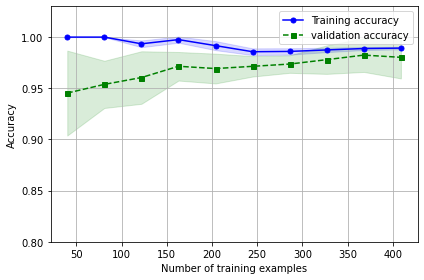

In [12]:
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(SDS(), LGR(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

- `learning_curve` 함수의 `train_sizes` 매개변수의 기본값은 `np.linspace(0.1, 1.0 ,5)
- `cv` 매개변수의 기본값은 5
- 회귀 문제일 때는 `KFold`를, 분류 문제일 경우 `StratifiedKFold`를 사용
- `shffle` 매개변수를 `True`로 지정하면 훈련 데이터셋을 사용하기 전에 섞음
- `return_times` 매개변수를 `True`로 지정하면 훈련과 평가에 걸린 시간을 반환
- `fit` 메서드에 필요한 매개변수와 값을 딕셔너리 형태로 지정할 수 있는 `fit_params` 매개변수 추가됨 (0.24버전)

## 3.2.검증 곡선으로 과대적합 과소적합 조사

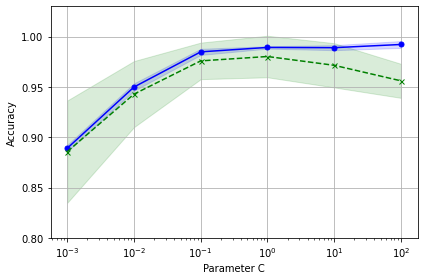

In [13]:
from sklearn.model_selection import validation_curve
param_range = [10**i for i in range(-3,3)]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='x', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([.8, 1.03])
plt.tight_layout()
plt.show()

- `validation_curve`는 함수 안에서 평가하기 원하는 매개변수를 지정함
- 규제 강도가 커질수록 과소적합, 0.001에서는 과대적합 되는 모습을 보임

# 4.그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

- 하이퍼파라미터 최적화
- 최적 하이퍼파라미터 조합을 찾음으로 모델 성능 향상

## 4.1.그리드 서치를 사용한 하이퍼파라미터 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(SDS(), SVC(random_state=1))
param_range = [10**i for i in range(-4, 4)]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__kernel': ['rbf']}
]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9868599033816425
{'svc__C': 10, 'svc__kernel': 'rbf'}


- 마지막으로 독립적인 테스트 데이터셋을 사용하고 최고 모델의 성능을 추정함
- `GridSearchCV`객체의 `best_estimator_` 속성에서 얻을 수 있음

In [15]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % (clf.score(X_test, y_test)))

Test Accuracy: 0.956


- **GridSearchCV에 대한 추가 사항**
    - `GridSearchCV` 클래스와 `cross_validate` 함수에서 `return_train_score` 매개변수를 True로 지정하면 훈련 폴드에 대한 점수를 계산하여 반환함
    - 훈련 데이터셋에 대한 점수를 보고 과대적합과 과소적합에 대한 정보를 얻을 수 있지만 실행 시간이 오래 걸릴 수 있음
    - `param_range`에 여덟 개의 값이 지정되어 있기 때문에 SVC 모델은 `linear`커널에서 8번, `rbf`커널에 대해 64번의 교차 검증이 수행 됨
    - 따라서 훈련 폴드마다 반환되는 점수는 72개
    - 이 값은 `GridSearchCV` 클래스의 `cv_results_` 딕셔너리 속성에 `split{폴드번호}_train_score`와 같은 키에 저장되어 있음


```python
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, return_train_score=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']
gs.cv_results_['mean_train_score']
gs.cv_results_['split0_test_score']
gs.score(X_test, y_test)
```

---
- **RandomizedSearchCV**
    - 그리드 서치는 최적 매개변수 조합을 찾는 강력한 도구이지만 가능한 모든 매개변수 조합을 평가하기 위해 계산 비용이 매우 많이 듦
    - 여러 매개변수 조합을 샘플링하는 다른 방법으로 랜덤 서치가 있음
    - 그리드 서치와 비슷한 성능을 내지만 훨씬 비용과 시간이 적게 듦
    - 특히 랜덤 서치에서 60개의 파라미터 조합이 있다면 최적의 성능에서 5% 이내에 있는 솔루션을 얻을 확률이 95%임
    - `RandomizedSearchCV` 클래스를 사용하여 제한된 횟수 안에서 샘플링 분포로부터 랜덤한 매개변수 조합을 뽑음
    - 매개변수 탐색 범위가 넓거나 규제 매개변수 `C`처럼 연속적인 값을 탐색해야 하는 경우 `RandomizedSearchCV`가 더 효율적
    - 해당 클래스는 `n_iter` 매개변수로 탐색 횟수를 조정할 수 있어 컴퓨팅 자원에 맞게 탐색을 실행할 수 있음
    -`GridSearchCV` 클래스에는 탐색할 매개변수 값을 리스트로 전달했지만, `RandomizedSearchCV`에는 샘플링 가능한 분포를 지정해야 함
    - 예시로 `scipy.stats.uniform, scipy.stats.randint` 객체 등이 있음
    - 0.22 버전에서는 `scipy.stats.reciprocal`을 사용한 로그 균등 분포 클래스 `loguniform`을 제공함

```python
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
distribution = loguniform(.0001, 1000.0)
param_dist = [{'svc__C': distribution, 'svc__kernel': ['linear']}, {'svc__C': distribution, 'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_dist, n_iter=30, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_scores_)
print(rs.best_params_)
```
---

- **HalvingGridSearchCV**
    - 모든 파라미터 조합에 대해 제한된 자원으로 실행한 후 가장 좋은 후보를 골라서 더 많은 자원을 투여하는 식으로 반복적으로 탐색을 수행
    - 이런 방식을 SH(Successive Halving)이라고 부름
    - `HalvingGridSearchCV`의 `resource` 매개변수는 반복마다 늘려 갈 자원을 정의
    - 기본값은 `n_samples`로 샘플 개수
    - 이외에도 탐색 대상 모델에서 양의 정수 값을 가진 매개변수를 지정할 수 있음(ex - 랜덤 포레스트의 `n_estimators`)
    - `factor` 매개변수는 반복마다 선택할 후보의 비율을 지정
    - 기본값은 3으로 후보 중에서 성능이 높은 1/3만 다음 반복으로 전달
    - `max_resources` 매개변수는 각 후보가 사용할 최대 자원을 지정 (기본값은 'auto'로 `resources='n_samples'`일 때 샘플 개수가 됨)
    - `min_resources`는 첫 번째 반복에서 각 후보가 사용할 최소 자원을 지정함 (`resources='n_samples'`이고 `min_resources='smallest'`이면 회귀일 때 $cv \times 2$가 되고, 분류일 때는 $cv \times 클래스\,개수 \times 2$가 됨, 그 외에는 1)
    - `min_resources='exhaust'`이면 앞에서 계산한 값과 `max_resources`를 `factor**n_required_iterations`로 나눈 몫 중 큰 값 (default: 'smallest', `n_required_iterations`는 $\log_{factor}(전체\,후보\,개수)+1$)
    - `aggressive_elimination` 매개변수를 `True`로 지정하면 마지막 반복에서 `factor`만큼 후보가 남을 수 있도록 자원을 늘리지 않고 초기에 반복을 여러번 진행 (default: False)


```python
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
hgs = HalvingGridSearchCV(estimator=pipe_svc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)
hgs = hgs.fit(X_train, y_train)
print(hgs.bset_score_)
print(hgs.best_params_)
print(np.lsum(hgs.cv_results_['mean_fit_time']))    # 교차검증에 걸린 시간
print('자원 리스트: ', hgs.n_resources_)
print('후보 리스트: ', hgs.n_candisates_)
```

## 4.2.중첩 교차 검증을 사용한 알고리즘 선택

- 그리스 서치와 k-겹 교차 검증을 함께 사용하면 머신 러닝 모델의 성능을 세부 튜닝하기에 좋음
- 여러 종류의 머신 러닝 알고리즘을 비교하려면 중첩 교차 검증 방법이 권장됨
- 오차 예측 편향 연구 중 바르마와 사이몬은 중첩된 교차 검증을 사용했을 때 테스트 데이터셋에 대한 추정 오차는 거의 편향되지 않는다는 결론을 얻음
- 중첩 교차 검증은 바깥쪽 k-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고 안쪽 루프가 훈련 폴드에서 k-겹 교차 검증을 수행하여 모델을 선택
- 모델이 선택되면 테스트 폴드를 사용하여 모델 성능을 평가

In [16]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.976 +/- 0.021


- 반환된 평균 교차 검증 점수는 모델의 하이퍼파라미터를 튜닝했을 때 처음 본 데이터에서 기대할 수 잇는 추정 값이 됨
- 예를 들어 중첩 교차 검증을 사용하여 SVM 모델과 단일 결정 트리 분류기를 비교할 수 있음

In [17]:
from sklearn.tree import DecisionTreeClassifier as DTC

gs = GridSearchCV(estimator=DTC(random_state=0), param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], scoring='accuracy', cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 +/- 0.016


# 5.여러 가지 성능 지표

- 일반적으로 분류 모델의 성능을 정량화하는 데 유용함
- 주어진 문제에 모델이 적합한지 측정할 수 있는 다른 성능 지표도 여러 존재함
- 정밀도, 재현율, F1-점수가 있음

## 5.1.오차 행렬

- 오차 행렬

|||예|측|
|--|--|--|--|
|||**N**|**P**|
|**실**|**N**|TN|FP|
|**제**|**P**|FN|TP|

- TP(진짜 양성), TN(진짜 음성), FP(거짓 양성), FN(거짓 음성)

In [18]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[71,  1],
       [ 2, 40]], dtype=int64)

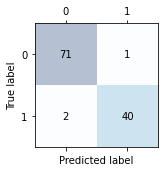

In [19]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

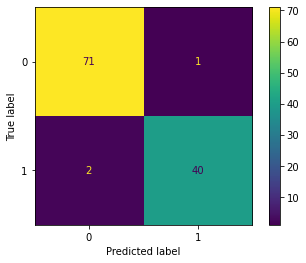

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
pipe_svc.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()

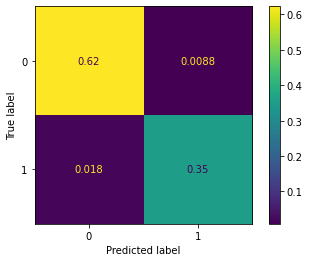

In [21]:
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, normalize='all')
plt.show()

## 5.2.분류 모델의 정밀도와 재현율 최적화

- 예측 오차(ERR)과 정확도(ACC) 모두 얼마나 많은 샘플을 잘못 분류했는지 일반적인 정보를 알려줌
- 정확도는 옳은 예측의 합을 전체 예측 샘플 개수로 나누어 계산

$$\begin{align*}
ERR &= \frac{FP+FN}{FP+FN+TP+TN} \\
ACC &= \frac{TP+TN}{FP+FN+TP+TN}=1-ERR
\end{align*}$$

- 진짜 양성 비율(TPR)과 거짓 양성 비율(FPR)은 클래스 비율이 다른 경우 유용한 성능 지표

$$\begin{align*}
FPR &= \frac{FP}{N} = \frac{FP}{FP+TN} \\
TPR &= \frac{TP}{P} = \frac{TP}{TP+FN}
\end{align*}$$

- 예를 들어 종양 진단 문제에서는 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는 데 관심이 있음
- 또 불필요하게 환자에게 걱정을 끼치지 않도록 음성 종양이 악성으로 분류되는 경우(FN)를 줄이는 것이 중요
- FPR에 비해서 TPR은 전체 양성 샘플(P) 중에서 올바르게 분류된 양성 샘플의 비율을 알려줌
- 정밀도(PRE)와 재현율(REC) 성능 지표는 진짜 양성과 진짜 음성 샘플의 비율과 관련이 있음

$$\begin{align*}
PRE &= \frac{TP}{TP+FP} \\
REC = TPR &= \frac{TP}{P} = \frac{TP}{TP+FN}
\end{align*}$$

- 악성 종양 감지 문제에서 재현율을 최적화하면 악성 종양을 감지하지 못할 확률을 최소화하는 데 도움이 됨
- 그러나 건강한 환자임에도 악성 종양으로 예측하는 비용이 발생(높은 FP 때문에)
- 반대로 정밀도를 최적화하면 환자가 악성 종양을 가졌는지 정확히 예측하게 됨
- 그러나 악성 종양 환자를 자주 놓치는 결과를 초래함 (높은 FN 때문에)
- PRE와 REC 최적화로 인한 장단점의 균형을 맞추기 위해 PRE와 REC를 조합한 F1-Score를 자주 사용

$$
F1 = 2\frac{PRE \times REC}{PRE + REC}
$$

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 Score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
recall_score: 0.952
F1 Score: 0.964


- 또한 `GridSearchCV`의 `scoring` 매개변수를 사용하여 정확도 대신 다른 성능 지표를 사용할 수 있음
- 사이킷런에서 양성 클래스는 레이블이 1인 클래스임
- 양성 레이블을 바꾸고 싶다면 `make_scorer`함수를 사용하여 자신만의 함수를 만들 수 있음
- 그 다음 `GridSearchCV`의 `scoring` 매개변수에 전달할 수 있음

In [23]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [10**i for i in range(-2, 3)]
param_grid = [
    {'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
    {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}
]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## 5.3.ROC 곡선 그리기

- ROC 그래프는 분류기의 임계 값을 바꾸어 가며 계산된 FPR과 TPR 점수를 기반으로 분류 모델을 선택하는 유용한 도구임
- ROC 그래프의 대각선은 랜덤 추측으로 해석할 수 있고 대각선 아래에 위치한 분류 모델은 랜덤 추측보다 나쁜 셈
- 완벽한 분류기의 그래프는 TPR이 1이고 FPR이 0인 왼쪽 위 구석에 위치함
- ROC 곡선의 아래면적인 ROC AUC를 계산하여 분류 모델의 성능을 종합할 수 있음
- ROC 곡선과 비슷하게 분류 모델의 확률 임계 값을 바꾸어 가며 정밀도-재현율 곡선을 그릴 수 있음
- 정밀도-재현율 곡선을 그리는 함수도 사이킷런에 구현되어 있음

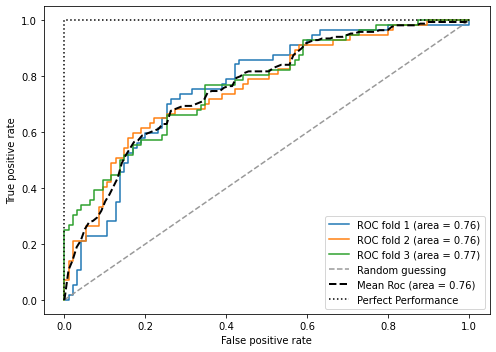

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from numpy import interp

pipe_lr = make_pipeline(SDS(), PCA(n_components=2), LGR(penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7,5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, threshold = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' %(i+1, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color=(.6, .6, .6), label='Random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean Roc (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect Performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 5.4.다중 분류의 성능 지표

- 사이킷런은 이런 평균 지표에 마크로와 카이크로 평균 방식을 구현하여 **OvA** 방식을 사용하는 다중 분류로 확장
- 마이크로 평균은 클래스 별로 TP, TN, FP, FN을 계산
- 예를 들어 k개의 클래스가 있는 경우 정밀도의 마이크로 평균은 다음과 같이 계산함
$$
PRE_{micro} = \frac{TP_1+\cdots+TP_k}{TP_1+\cdots+TP_k+FP_1+\cdots+FP_k}
$$
- 마크로 평균은 단순하게 클래스별 정밀도의 평균
$$
PRE_{macro} = \frac{PRE_1+\cdots+PRE_k}{k}
$$
- 마이크로 평균 : 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용
- 마크로 평균 : 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가
- 가장 빈도 높은 클래스 레이블의 성능이 중요
- 사이킷런에서 이진 성능 지표로 다중 분류 모델을 평가하면 정규화 또는 가중치가 적용된 마크로 평균이 기본으로 적용됨
- 가중치가 적용된 마크로 평균은 평균을 계산할 때 각 클래스 레이블의 샘플 개수를 가중하여 계산
- 가중치가 적용된 마크로 평균은 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰 때 유용함
- 사이킷런에서 가중치가 적용된 마크로 평균이 다중 분류 문제에서 기본값이지만 `sklearn.metrics` 모듈 아래에 있는 측정 함수들은 `average` 매개변수로 평균 계산 방식을 지정할 수 있음

```python
pre_scorer = make_socrer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')
```

# 6.불균형한 클래스 다루기

- 스팸 필터링, 부정 감지, 질병 차단 등에서 발생할 수 있는 문제
- 우선 유방암 데이터 셋을 불균한 데이터 셋으로 바꾸어서 실습 진행

In [27]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [29]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred==y_imb)*100

89.92443324937027

- 이 경우에 있어서 정확도 보다 다른 지표 활용이 나음
- 주요 관심 대상이 무엇인지에 따라 정밀도, 재현율, ROC 곡선 등을 사용할 수 있음
- 예를 들어 추가적인 검사가 필요한 악성 종양 환자의 대부분을 구별하는 것이 가장 중요할 수 있음
- 여기서는 재현율 지표를 선택할 것
- 스팸 필터의 경우 햄 이메일이 너무 자주 스팸으로 처리되는 것을 원치 않기 때문에 정밀도가 더 적절한 지표
- 클래스 불균형은 모델이 훈련되는 동안 학습 알고리즘 자체에 영향을 미침
- 머신러닝 알고리즘이 일반적으로 훈련하는 동안 처리한 샘플에서 계산한 보상 또는 비용 함수의 합을 최적화함
- 결정 규칙은 다수 클래스 쪽으로 편향되기 쉬움
- 즉, 알고리즘이 훈련 과정에서 비용을 최소화하거나 보상을 최대화하기 위해 데이터셋에서 가장 빈도가 높은 클래스의 예측을 최적화하는 모델을 찾음
- 불균형한 클래스를 다루는 방법
    1. 소수 클래스에서 발생한 예측 오류에 큰 벌칙을 부여
        - 사이킷런에서 대부분의 분류기에 구현된 `class_weight` 매개변수를 `class_weight='balanced'`로 설정해서 이런 벌칙을 편리하게 조정할 수 있음
    2. 소수 클래스 샘플을 늘리거나 다수 클래스의 샘플을 줄임
        - 여러 도메인에 거친 보편적 솔루션은 존재하지 않음
        - 실전에서 주어진 문제에 여러 전략을 시도하고 결과를 평가하면서 가장 적절한 기법을 찾아 내는 것이 중요

In [31]:
from sklearn.utils import resample

print('샘플링 전 클래스 1의 샘플 개수: ', X_imb[y_imb==1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb==1], y_imb[y_imb==1], replace=True, n_samples=X_imb[y_imb==0].shape[0], random_state=123)

print('샘플링 후 클래스 1의 샘플 개수: ', X_upsampled.shape[0])

샘플링 전 클래스 1의 샘플 개수:  40
샘플링 후 클래스 1의 샘플 개수:  357


In [32]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred==y_bal)*100

50.0